In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [209]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

# Processamento dos dados

In [32]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 
prodomal_data =  parkinson.utils.data.batch_read('../data/Prodomals_columns') 

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Geração da matriz de correlação utilizando o método especificado para os grupos
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 39.79it/s]


- 0: control
- 1: prodomal
- 2: PD

In [51]:
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))], [2 for _ in range(len(parkinson_data))])
X, y = parkinson.utils.data.filter_data(X, y)

In [75]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1/9, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

### Subset 'healthcheck'
Contém todos os pacientes. Queremos separar entre saudáveis e não saudáveis (Parkinson ou Prodomal)

In [73]:
def get_healthcheck(X: np.array, y: np.array) -> tuple[np.array, np.array]:
    y_hcheck = y.copy()
    y_hcheck[y_hcheck == 2] = 1
    return X, y_hcheck

### Subset 'pdstage'
Contém pacientes não saudáveis. Queremos identificar o estágio da doença (inicial ou avançado)

In [210]:
def get_pdstage(X: np.array, y: np.array) -> tuple[np.array, np.array]:
    nhealthy_index = y != 0
    y_pdstage = y.copy()
    X_pdstage = X.copy()
    y_pdstage = y_pdstage[nhealthy_index] - 1
    X_pdstage = X_pdstage[nhealthy_index]
    return X_pdstage, y_pdstage

## Health Check

In [82]:
X_train_hcheck, y_train_hcheck = get_healthcheck(X_train, y_train)
X_test_hcheck, y_test_hcheck = get_healthcheck(X_test, y_test)
X_val_hcheck, y_val_hcheck = get_healthcheck(X_val, y_val)

train_loader = parkinson.utils.data.get_torch_dataloader(X_train_hcheck, y_train_hcheck, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val_hcheck, y_val_hcheck, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test_hcheck, y_test_hcheck, batch_size=BATCH_SIZE)

### Treinamento

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train_hcheck) # Atencao no y utilizado!

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

train_results = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/1_correlation_matrix"
)

train-loss: 0.1866  train-acc: 0.9967 | val-loss: 0.5619  val-acc: 0.6765:  38%|█████████████████████████████▋                                                | 76/200 [00:26<00:43,  2.84it/s]

Early stopping at epoch 77


### Teste

In [215]:
path="../weights/1_correlation_matrix"

if path is not None:
    model.load_state_dict(torch.load( f"{path}/best_model.pth", map_location=device))
model.eval()

all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        nonhealthy_probs = out.softmax(1)[:, 1]
        all_preds.extend([int(p) for p in preds.cpu().numpy()])
        all_labels.extend(y.cpu().numpy())
        all_probs.extend([float(p) for p in nonhealthy_probs.cpu().numpy()])

In [216]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

metrics = {
    'preds': all_preds,
    'labels': all_labels,
    'acc': accuracy_score(all_labels, all_preds),
    'f1':  f1_score(all_labels, all_preds, average='weighted'),
    'precision': precision_score(all_labels, all_preds, average='weighted'),
    'recall':  recall_score(all_labels, all_preds, average='weighted')
}

### Análise dos resultados

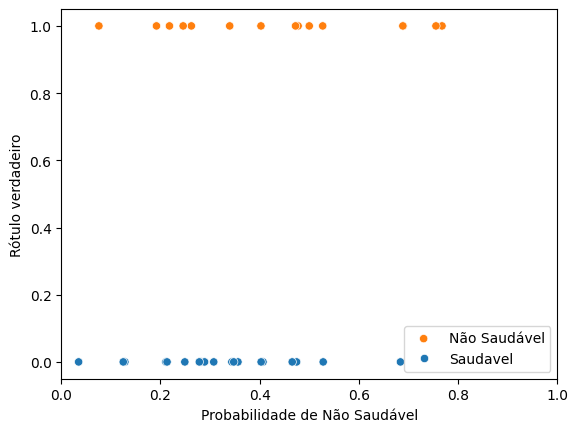

In [219]:
sns.scatterplot(x=all_probs, y=all_labels, hue=all_labels)
plt.xlabel('Probabilidade de Não Saudável')
plt.ylabel('Rótulo verdadeiro')
plt.xlim(0, 1)
plt.legend(['Não Saudável', 'Saudavel'])

 Acurácia       F1  Precisão   Recall
 0.647059 0.613578  0.666978 0.647059


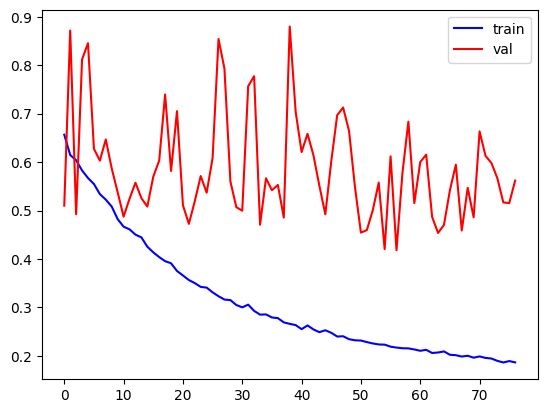

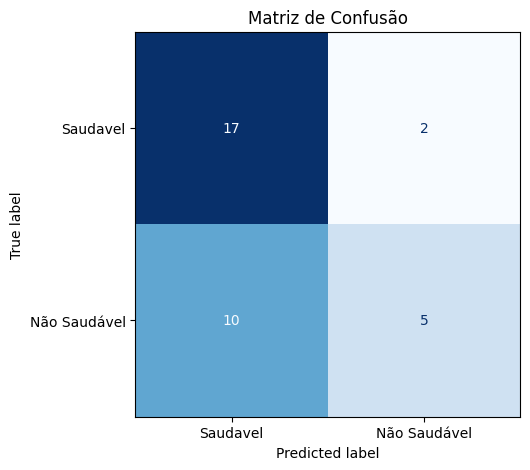

In [218]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
parkinson.utils.results.plot_losses(train_results['train_loss'], train_results['val_loss'])
parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Saudavel','Não Saudável'])
plt.show()

## Parkinson Stage

Agora vamos focar em aumentar a acurácia já que possuímos classes balanceadas

In [203]:
X_train_pdstage, y_train_pdstage = get_pdstage(X_train, y_train)
X_test_pdstage, y_test_pdstage = get_pdstage(X_test, y_test)
X_val_pdstage, y_val_pdstage = get_pdstage(X_val, y_val)

train_loader = parkinson.utils.data.get_torch_dataloader(X_train_pdstage, y_train_pdstage, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val_pdstage, y_val_pdstage, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test_pdstage, y_test_pdstage, batch_size=BATCH_SIZE)

In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train_pdstage) # Atencao no y utilizado!

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

train_results = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/1_correlation_matrix"
)

train-loss: 0.1513  train-acc: 1.0000 | val-loss: 0.7617  val-acc: 0.5588:  31%|████████████████████████▏                                                     | 62/200 [00:22<00:49,  2.81it/s]

Early stopping at epoch 63


In [206]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device, path="../weights/1_correlation_matrix")

 Acurácia       F1  Precisão   Recall
 0.647059 0.647059  0.647059 0.647059


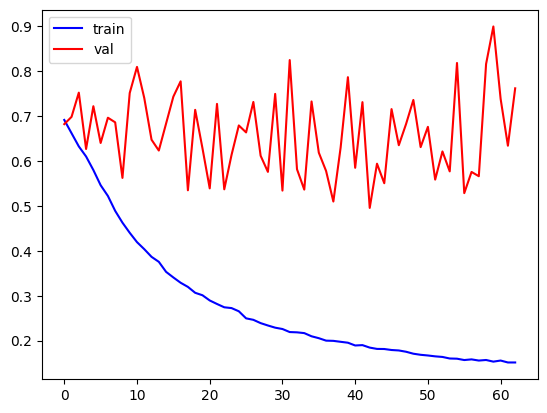

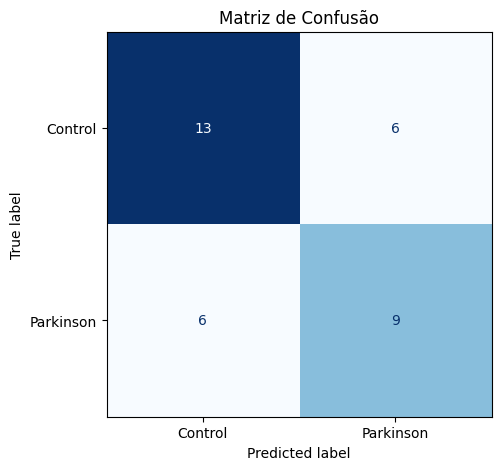

In [207]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
parkinson.utils.results.plot_losses(train_results['train_loss'], train_results['val_loss'])
parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
plt.show()